# Real Time Driver Drowsiness Detection System 

## Install Modules

In [1]:
# visual c++, cmake - install in local machine
# pip install cmake
# pip install dlib-19.24.99-cp312-cp312-win_amd64.whl
# pip install face_recognition

## Import Modules

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance
import dlib
import logging
from datetime import datetime
import pygame
import threading
import time
import warnings


warnings.filterwarnings('ignore')


pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Highlight Facial Points in the Image

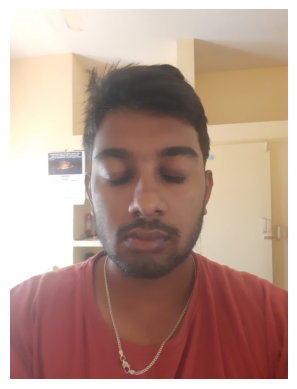

In [6]:
image_path = 'test1.png'
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [7]:
def highlight_facial_points(image_path):
    # load the image
    image_bgr = cv2.imread(image_path)
    # convert from bgr to rgb
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    face_locations = face_recognition.face_locations(image_rgb, model='hog')

    for face_location in face_locations:
        # get facial landmarks
        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        # Iterate over the facial landmarks and draw them on the image
        for landmark_type, landmark_points in landmarks.items():
            for (x, y) in landmark_points:
                cv2.circle(image_rgb, (x, y), 3, (0, 255, 0), -1)

    # plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

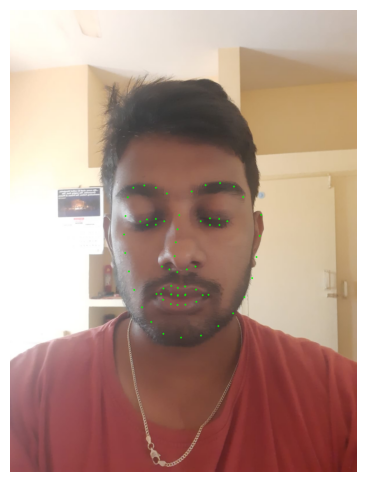

In [8]:
highlight_facial_points(image_path)

## Aspect Ratio Calculations


In [9]:
# calculate eye aspect ratio
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A+B) / (2.0 * C)
    return ear

# calculate mount aspect ratio
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A+B) / (2.0 * C)
    return mar

## Drowsiness Detection in Images

In [10]:
def process_image(frame):
    # define thresholds
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image is not found or unable to open')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # find all face locations
    face_locations = face_recognition.face_locations(rgb_frame)

    # initiate flags
    eye_flag = mouth_flag = False

    for face_location in face_locations:
        # extract facial landmarks
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        # extract eye and mouth coordinates
        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        # calculate ear and mar
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear+right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        # check if eyes are closed
        if ear < EYE_AR_THRESH:
            eye_flag = True

        # check if yawning
        if mar > MOUTH_AR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

In [11]:
img = cv2.imread(image_path)
eye_flag, mouth_flag = process_image(img)
print("Eyes closed:", eye_flag, "Yawning:", mouth_flag)

Eyes closed: True Yawning: False


## Real Time Drowsiness Detection

In [ ]:
class DriverDrowsinessDetector:
    def __init__(self, 
                 eye_thresh=0.25, 
                 mouth_thresh=0.6, 
                 frame_check=5, 
                 drowsy_threshold=15):
        """
        Advanced driver drowsiness detection system
        
        :param eye_thresh: Eye aspect ratio threshold for drowsiness
        :param mouth_thresh: Mouth aspect ratio threshold for yawning
        :param frame_check: Frames to process between detection
        :param drowsy_threshold: Score threshold for drowsiness alert
        """
        # Detection parameters
        self.eye_thresh = eye_thresh
        self.mouth_thresh = mouth_thresh
        self.frame_check = frame_check
        self.drowsy_threshold = drowsy_threshold
        
        # Face detection setup
        self.detector = dlib.get_frontal_face_detector()
        
        # Logging configuration
        self.setup_logging()
        
        # Alert sound setup
        self.setup_alert_sound()

    def setup_logging(self):
        """Configure logging for drowsiness events"""
        log_filename = f'drowsiness_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
        logging.basicConfig(
            filename=log_filename, 
            level=logging.INFO,
            format='%(asctime)s - %(message)s'
        )
        self.logger = logging.getLogger()

    def setup_alert_sound(self):
        """Initialize alert sound for drowsiness"""
        pygame.mixer.init()
        try:
            self.alert_sound = pygame.mixer.Sound('alarm.wav')
        except:
            self.alert_sound = None
            print("Alert sound not found. Using visual alerts only.")

    def play_alert_sound(self):
        """Play alert sound in a separate thread"""
        if self.alert_sound:
            threading.Thread(target=self.alert_sound.play, daemon=True).start()

    def eye_aspect_ratio(self, eye):
        """
        Calculate eye aspect ratio to detect eye closure
        
        :param eye: Eye landmark points
        :return: Eye aspect ratio
        """
        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def mouth_aspect_ratio(self, mouth):
        """
        Calculate mouth aspect ratio to detect yawning
        
        :param mouth: Mouth landmark points
        :return: Mouth aspect ratio
        """
        A = distance.euclidean(mouth[2], mouth[10])
        B = distance.euclidean(mouth[4], mouth[8])
        C = distance.euclidean(mouth[0], mouth[6])
        return (A + B) / (2.0 * C)

    def detect_drowsiness(self, frame):
        """
        Detect drowsiness indicators in real-time
        
        :param frame: Input video frame
        :return: Drowsiness metrics
        """
        # Color conversions
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Detect faces
        faces = self.detector(gray_frame)
        
        drowsiness_metrics = {
            'eye_closed': False,
            'yawning': False,
            'faces_detected': len(faces) > 0
        }

        for face in faces:
            # Facial landmarks detection
            landmarks = face_recognition.face_landmarks(rgb_frame, [(face.top(), face.right(), face.bottom(), face.left())])[0]
            
            # Eye and mouth landmark extraction
            left_eye = np.array(landmarks['left_eye'])
            right_eye = np.array(landmarks['right_eye'])
            mouth = np.array(landmarks['bottom_lip'])

            # Calculate aspect ratios
            left_ear = self.eye_aspect_ratio(left_eye)
            right_ear = self.eye_aspect_ratio(right_eye)
            ear = (left_ear + right_ear) / 2.0
            mar = self.mouth_aspect_ratio(mouth)

            # Drowsiness indicators
            if ear < self.eye_thresh:
                drowsiness_metrics['eye_closed'] = True
                self.logger.warning("Eyes closed")
            
            if mar > self.mouth_thresh:
                drowsiness_metrics['yawning'] = True
                self.logger.warning("Potential yawning detected")

        return drowsiness_metrics

    def start_detection(self):
        """
        Start real-time drowsiness detection using webcam
        """
        video_cap = cv2.VideoCapture(0)  # Default webcam
        
        count = score = consecutive_alerts = 0
        while True:
            success, frame = video_cap.read()
            if not success:
                break

            # Resize frame for processing
            frame = cv2.resize(frame, (800, 500))
            count += 1

            # Detection every nth frame
            if count % self.frame_check == 0:
                metrics = self.detect_drowsiness(frame)
                
                # Scoring logic
                if metrics['eye_closed'] or metrics['yawning']:
                    score += 2
                else:
                    score = max(0, score - 1)

                # Drowsiness alert
                if score >= self.drowsy_threshold:
                    consecutive_alerts += 1
                    cv2.putText(frame, 'DROWSY ALERT', (frame.shape[1]-250, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    
                    # Sound and logging for persistent drowsiness
                    if consecutive_alerts % 5 == 0:
                        self.play_alert_sound()
                        self.logger.critical("CRITICAL: Persistent Drowsiness Detected!")
                else:
                    consecutive_alerts = 0

                # Display metrics
                cv2.putText(frame, f'Drowsiness Score: {score}', (10, frame.shape[0]-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # No face detection warning
                if not metrics['faces_detected']:
                    cv2.putText(frame, 'NO FACE DETECTED', (10, 30), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            cv2.imshow('Driver Drowsiness Detection', frame)

            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Cleanup
        video_cap.release()
        cv2.destroyAllWindows()

def main():
    """Main execution function"""
    try:
        detector = DriverDrowsinessDetector()
        detector.start_detection()
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()